<a href="https://colab.research.google.com/github/abhaygangwar3/Ankii-s-Portfolio/blob/master/Complex_Deep_Learning_Pipeline_involving_CNN_models%2CAug%2C_HOG_%26_SIFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This code creates an ensemble of CNN models, applies data augmentation, uses regularization to avoid overfitting,
#  and performs both training and evaluation, followed by feature visualization with HOG and SIFT.from google.colab import drive

import tensorflow as tf
from google.colab import drive
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Average
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import cv2
from skimage.feature import hog
from skimage import exposure
import itertools
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

# Mount Google Drive
drive.mount('/content/drive')

# The training, validation, and test datasets are loaded from .npz files on Google Drive.
#The datasets contain images and labels that will be used for training, validation, and testing of the CNN models.
data_train = np.load('/content/drive/MyDrive/All OPG Gender ML/Train.npz')
data_test = np.load('/content/drive/MyDrive/All OPG Gender ML/Test.npz')
data_val = np.load('/content/drive/MyDrive/All OPG Gender ML/Val.npz')

images_train = data_train['images']
labels_train = data_train['labels']
images_val = data_val['images']
labels_val = data_val['labels']
images_test = data_test['images']
labels_test = data_test['labels'].astype(np.float32)

# This ensures that the shape of the images is consistent. It swaps the axes of the image arrays if needed.
images_test = np.transpose(images_test, (0, 2, 1, 3))  # Transpose if needed

#Converts RGB images to grayscale using standard weights for each color channel (red, green, blue).
def rgb_to_grayscale(images):
    return np.dot(images[...,:3], [0.2989, 0.5870, 0.1140])

# Convert images to grayscale
images_train = rgb_to_grayscale(images_train)
images_val = rgb_to_grayscale(images_val)
images_test = rgb_to_grayscale(images_test)

# Adds a channel dimension to the grayscale images to make them compatible with the CNN layers, which expect a 4D input (batch size, height, width, channels).
images_train = np.expand_dims(images_train, axis=-1)
images_val = np.expand_dims(images_val, axis=-1)
images_test = np.expand_dims(images_test, axis=-1)

# Normalizes the pixel values of the images to be in the range [0, 1].
images_train = images_train / 255.0
images_val = images_val / 255.0
images_test = images_test / 255.0
if images_test.ndim == 3:  # If missing the channel dimension
    images_test = np.expand_dims(images_test, axis=-1)

# One-hot encodes the labels (for male/female classification), converting them into two categories (e.g., [1, 0] for male and [0, 1] for female).
num_classes = 2
labels_train = to_categorical(labels_train, num_classes=num_classes)
labels_val = to_categorical(labels_val, num_classes=num_classes)
labels_test = to_categorical(labels_test, num_classes=num_classes)

from sklearn.utils.class_weight import compute_class_weight

# Get integer labels from one-hot encoded labels
labels_train_int = np.argmax(labels_train, axis=1)

# Calculates class weights to handle class imbalance in the training data, ensuring that the model does not become biased toward one class.
class_weights = compute_class_weight('balanced', classes=np.unique(labels_train_int), y=labels_train_int)
class_weights = dict(enumerate(class_weights))

# CNN Model Creation with L2 Regularization
from tensorflow.keras.regularizers import l2

def create_cnn_model(input_shape):
    l2_reg = 1e-4  # Adjust the regularization factor if needed

    inputs = Input(shape=input_shape)

    # First CNN block
    x = Conv2D(96, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg))(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    # Second CNN block
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    # Third CNN block
    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = MaxPooling2D((2, 2))(x)

    # Fourth CNN block
    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten and Fully Connected Layers
    x = Flatten()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(0.6)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(0.5)(x)

    # Output layer with sigmoid for binary classification
    # outputs = Dense(1, activation='sigmoid')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model



# Define input shape
input_shape = (360, 120, 1)  # Ensure this matches the shape of your images

# Ensemble of CNN Models
cnn1 = create_cnn_model(input_shape)
cnn2 = create_cnn_model(input_shape)
cnn3 = create_cnn_model(input_shape)

# Define input layer
inputs = Input(shape=input_shape)

# Get predictions from each CNN
cnn1_output = cnn1(inputs)
cnn2_output = cnn2(inputs)
cnn3_output = cnn3(inputs)

# Average the predictions (soft voting)
avg_output = Average()([cnn1_output, cnn2_output, cnn3_output])

# Create the ensemble model
ensemble_model = Model(inputs, avg_output)

# Compile the model
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks, Larger or More Complex Models (like transformers, deeper CNNs):

#lr = 0.0003 (3e-4) to 0.00001 (1e-5).
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=5e-6)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Image data generators for training and validation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    rescale=1./255  # Normalize pixel values
)

val_datagen = ImageDataGenerator(
    rescale=1./255  # Normalize pixel values
)

# Create generators
train_generator = train_datagen.flow(
    images_train,
    labels_train,
    batch_size=16
)

val_generator = val_datagen.flow(
    images_val,
    labels_val,
    batch_size=16
)

# Define epochs and batch_size
epochs = 4
batch_size = 16

# Ensure correct steps_per_epoch calculation
steps_per_epoch = len(images_train) // batch_size
validation_steps = len(images_val) // batch_size

# Now, pass class_weights into the model.fit function
history = ensemble_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weights  # Apply the computed class weights here
)
# Load the best model
ensemble_model.load_weights('best_model.keras')

# Evaluate on test data
test_loss, test_acc = ensemble_model.evaluate(images_test, labels_test)
print(f'Test Accuracy: {test_acc:.4f}')

# Plotting Training & Validation Loss and Accuracy
def plot_training_history(history):
    # Plot the training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

    # Plot the training and validation accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.show()

plot_training_history(history)


#Plots confusion matrices to visualize the performance of the model on validation and test datasets.

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Predictions on validation and test data
val_predictions = np.argmax(ensemble_model.predict(images_val), axis=1)
test_predictions = np.argmax(ensemble_model.predict(images_test), axis=1)

# Convert one-hot encoded labels to integer labels
labels_val_int = np.argmax(labels_val, axis=1) if labels_val.ndim > 1 else labels_val
labels_test_int = np.argmax(labels_test, axis=1) if labels_test.ndim > 1 else labels_test

plot_confusion_matrix(labels_val_int, val_predictions, classes=['Male', 'Female'], title='Confusion Matrix (Validation)')
plot_confusion_matrix(labels_test_int, test_predictions, classes=['Male', 'Female'], title='Confusion Matrix (Test)')

# Classification Report
print("Validation Set Classification Report:")
print(classification_report(labels_val_int, val_predictions, target_names=['Male', 'Female']))

print("Test Set Classification Report:")
print(classification_report(labels_test_int, test_predictions, target_names=['Male', 'Female']))

# HOG Feature Extraction
from skimage.feature import hog
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

from skimage.transform import resize

#Extracts Histogram of Oriented Gradients (HOG) features from an image and visualizes the original and HOG-transformed image.
def visualize_hog(image, target_size=(128, 64)):
    # If the image has an extra channel dimension (e.g., 360, 120, 1), squeeze it out
    if image.shape[-1] == 1:
        image = np.squeeze(image, axis=-1)  # Remove the last channel

    # Resize the image to the target size (e.g., 128x64)
    resized_image = resize(image, target_size, anti_aliasing=True)

    # Calculate HOG features and HOG image
    fd, hog_image = hog(resized_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    # Rescale the HOG image for better visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Plot the original and HOG image side by side
    plt.figure(figsize=(8, 4))

    # Display the resized original grayscale image
    plt.subplot(1, 2, 1)
    plt.title('Original Resized Image')
    plt.imshow(resized_image, cmap='gray')  # Display the resized grayscale image
    plt.axis('off')  # Hide the axes

    # Display the HOG image
    plt.subplot(1, 2, 2)
    plt.title('HOG Image')
    plt.imshow(hog_image_rescaled, cmap='gray')  # Display the rescaled HOG image
    plt.axis('off')  # Hide the axes

    plt.show()

# Test the function
visualize_hog(images_train[0])


import numpy as np

import cv2
import numpy as np
import matplotlib.pyplot as plt

#Extracts and visualizes Scale-Invariant Feature Transform (SIFT) keypoints from an image.

def visualize_sift(image):
    # If the image has an extra channel dimension (e.g., 360, 120, 1), squeeze it out
    if image.shape[-1] == 1:
        image = np.squeeze(image, axis=-1)  # Remove the last channel

    print(f"Processed image shape: {image.shape}")

    # Ensure the image is of the right type (SIFT requires uint8)
    if image.dtype != 'uint8':
        image = (image * 255).astype('uint8')  # Convert to uint8 if needed

    # Convert the image to 3 channels if needed (SIFT can work with grayscale, but sometimes performs better with 3 channels)
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Apply Gaussian blur to reduce noise (optional but often helps)
    image = cv2.GaussianBlur(image, (5, 5), 0)

    # SIFT feature extraction
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)

    if keypoints is None or len(keypoints) == 0:
        print("No keypoints detected.")
        return None, None

    # Draw keypoints on the image
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Plot the image with SIFT keypoints
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display in Matplotlib
    plt.title("SIFT Keypoints")
    plt.axis('off')
    plt.show()

    return keypoints, descriptors

# Test the function
keypoints, descriptors = visualize_sift(images_train[0])




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 8/35 ━━━━━━━━━━━━━━━━━━━━ 21:43 48s/step - accuracy: 0.4860 - loss: 1.5344

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Processed image shape: (360, 120)


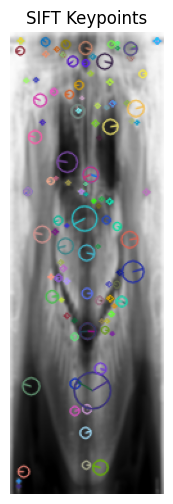

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_sift(image):
    # If the image has an extra channel dimension (e.g., 360, 120, 1), squeeze it out
    if image.shape[-1] == 1:
        image = np.squeeze(image, axis=-1)  # Remove the last channel

    print(f"Processed image shape: {image.shape}")

    # Ensure the image is of the right type (SIFT requires uint8)
    if image.dtype != 'uint8':
        image = (image * 255).astype('uint8')  # Convert to uint8 if needed

    # Convert the image to 3 channels if needed (SIFT can work with grayscale, but sometimes performs better with 3 channels)
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Apply Gaussian blur to reduce noise (optional but often helps)
    image = cv2.GaussianBlur(image, (5, 5), 0)

    # SIFT feature extraction
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)

    if keypoints is None or len(keypoints) == 0:
        print("No keypoints detected.")
        return None, None

    # Draw keypoints on the image
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Plot the image with SIFT keypoints
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display in Matplotlib
    plt.title("SIFT Keypoints")
    plt.axis('off')
    plt.show()

    return keypoints, descriptors

# Test the function
keypoints, descriptors = visualize_sift(images_train[0])


No L2 regularization and class weights

In [ ]:
import tensorflow as tf
from google.colab import drive
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Average
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive
drive.mount('/content/drive')

# Load data
data_train = np.load('/content/drive/MyDrive/All OPG Gender ML/Train.npz')
data_test = np.load('/content/drive/MyDrive/All OPG Gender ML/Test.npz')
data_val = np.load('/content/drive/MyDrive/All OPG Gender ML/Val.npz')

images_train = data_train['images']
labels_train = data_train['labels']
images_val = data_val['images']
labels_val = data_val['labels']
images_test = data_test['images']
labels_test = data_test['labels']

# Convert to grayscale
def rgb_to_grayscale(images):
    return np.dot(images[...,:3], [0.2989, 0.5870, 0.1140])

images_train = rgb_to_grayscale(images_train)
images_val = rgb_to_grayscale(images_val)
images_test = rgb_to_grayscale(images_test)

# Reshape to add a channel dimension
images_train = np.expand_dims(images_train, axis=-1)
images_val = np.expand_dims(images_val, axis=-1)
images_test = np.expand_dims(images_test, axis=-1)

# Convert to binary labels
labels_train = np.argmax(labels_train, axis=1)
labels_val = np.argmax(labels_val, axis=1)
labels_test = np.argmax(labels_test, axis=1)

# CNN Model without L2 Regularization
def create_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(96, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.6)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer with one unit for binary classification
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

# Input shape
input_shape = (360, 120, 1)

# Create ensemble of CNNs
cnn1 = create_cnn_model(input_shape)
cnn2 = create_cnn_model(input_shape)
cnn3 = create_cnn_model(input_shape)

# Ensemble
inputs = Input(shape=input_shape)
cnn1_output = cnn1(inputs)
cnn2_output = cnn2(inputs)
cnn3_output = cnn3(inputs)
avg_output = Average()([cnn1_output, cnn2_output, cnn3_output])

ensemble_model = Model(inputs, avg_output)

# Compile model
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=5e-6)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(images_train, labels_train, batch_size=16)
val_generator = val_datagen.flow(images_val, labels_val, batch_size=16)

# Training
epochs = 4
batch_size = 16
steps_per_epoch = len(images_train) // batch_size
validation_steps = len(images_val) // batch_size

history = ensemble_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

# Evaluate the model on test data
images_test_rescaled = images_test / 255.0
predictions = (ensemble_model.predict(images_test_rescaled) > 0.5).astype("int32")

# Generate confusion matrix
conf_matrix = confusion_matrix(labels_test, predictions)

# Display confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report for detailed metrics
print(classification_report(labels_test, predictions, target_names=['Male', 'Female']))


Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.5065 - loss: 2.4159 - val_accuracy: 0.3438 - val_loss: 0.8603 - learning_rate: 0.0010
Epoch 2/4
 1/35 ━━━━━━━━━━━━━━━━━━━━ 15s 443ms/step - accuracy: 0.6250 - loss: 0.6654

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


35/35 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6250 - loss: 0.6654 - val_accuracy: 0.7000 - val_loss: 0.6134 - learning_rate: 0.0010
Epoch 3/4
35/35 ━━━━━━━━━━━━━━━━━━━━ 49s 393ms/step - accuracy: 0.5156 - loss: 1.0823 - val_accuracy: 0.6146 - val_loss: 0.6726 - learning_rate: 0.0010
Epoch 4/4
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6250 - loss: 0.6401 - val_accuracy: 0.7000 - val_loss: 0.6134 - learning_rate: 0.0010


Remove L2 and class weights

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Average
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load training, validation, and test data
data_train = np.load('/content/drive/MyDrive/All OPG Gender ML/Train.npz')
data_test = np.load('/content/drive/MyDrive/All OPG Gender ML/Test.npz')
data_val = np.load('/content/drive/MyDrive/All OPG Gender ML/Val.npz')

images_train = data_train['images']
labels_train = data_train['labels']
images_val = data_val['images']
labels_val = data_val['labels']
images_test = data_test['images']
labels_test = data_test['labels']

# Convert RGB images to grayscale
def rgb_to_grayscale(images):
    return np.dot(images[...,:3], [0.2989, 0.5870, 0.1140])

images_train = rgb_to_grayscale(images_train)
images_val = rgb_to_grayscale(images_val)
images_test = rgb_to_grayscale(images_test)

# Add a channel dimension to the grayscale images
images_train = np.expand_dims(images_train, axis=-1)
images_val = np.expand_dims(images_val, axis=-1)
images_test = np.expand_dims(images_test, axis=-1)

# Normalize the pixel values
images_train = images_train / 255.0
images_val = images_val / 255.0
images_test = images_test / 255.0


# CNN Model without L2 Regularization
def create_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(96, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.6)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer with one unit for binary classification
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

# Input shape
input_shape = (360, 120, 1)

# Create ensemble of CNNs
cnn1 = create_cnn_model(input_shape)
cnn2 = create_cnn_model(input_shape)
cnn3 = create_cnn_model(input_shape)

# Ensemble
inputs = Input(shape=input_shape)
cnn1_output = cnn1(inputs)
cnn2_output = cnn2(inputs)
cnn3_output = cnn3(inputs)
avg_output = Average()([cnn1_output, cnn2_output, cnn3_output])

ensemble_model = Model(inputs, avg_output)

# Compile model
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=5e-6)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(images_train, labels_train, batch_size=16)
val_generator = val_datagen.flow(images_val, labels_val, batch_size=16)

# Training
epochs = 5
batch_size = 16
steps_per_epoch = len(images_train) // batch_size
validation_steps = len(images_val) // batch_size

history = ensemble_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

# Load the best model
ensemble_model.load_weights('best_model.keras')

# Ensure correct shapes and types
print(images_test.shape)  # Check shape

# Normalize and reshape if necessary
images_test = images_test / 255.0
if images_test.ndim == 3:  # If missing the channel dimension
    images_test = np.expand_dims(images_test, axis=-1)

labels_test = labels_test.astype(np.float32)  # Ensure correct type

# Evaluate on test data
test_loss, test_acc = ensemble_model.evaluate(images_test, labels_test)
print(f'Test Accuracy: {test_acc:.4f}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.5212 - loss: 0.8885 - val_accuracy: 0.3854 - val_loss: 0.7189 - learning_rate: 0.0010
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - accuracy: 0.7500 - loss: 0.7096 - val_accuracy: 0.3000 - val_loss: 0.7336 - learning_rate: 0.0010
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5713 - loss: 0.7344 - val_accuracy: 0.3750 - val_loss: 0.6992 - learning_rate: 0.0010
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4375 - loss: 0.7306 - val_accuracy: 0.4000 - val_loss: 0.6982 - learning_rate: 0.0010
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 406ms/step - accuracy: 0.5281 - loss: 0.7770 - val_accuracy: 0.3750 - val_loss: 0.7106 - learning_rate: 0.0010
(12, 120, 360, 1)


ValueError: Input 0 of layer "functional_15" is incompatible with the layer: expected shape=(None, 360, 120, 1), found shape=(None, 120, 360)

In [ ]:
print(f"Test images shape after reshaping: {images_test.shape}")


Test images shape after reshaping: (12, 120, 360, 1)


In [ ]:
print(images_test.shape)  # Should be (num_samples, 360, 120, 1)


(12, 120, 360, 1)


In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()


In [ ]:
 bg